GAN生成手写数字，使用Mnist数据集，pytorch

In [17]:
import torch
import torch.nn as nn
import numpy

In [18]:
# 配置数据
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE=32
img_size=28*28
hidden_size=256
latent_size=128
EPOCHS=128
lr=2e-4 # learning rate

In [29]:
# GAN Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 全连接层1 输入为img size, 输出为hidden size
        self.layer1 = nn.Linear(img_size, hidden_size)
        # 激活函数1 LeakyReLU
        self.actF1 = nn.LeakyReLU(0.2) # negative_slope=0.2
        # 全连接层2 输入为hidden size, 输出为hidden size
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        # 全连接层3 输入为hidden size, 输出为1
        self.layer3 = nn.Linear(hidden_size, 1)
        # 激活函数2 sigmoid 将变量映射到区间(0, 1) 常用于二分类问题
        self.actF2 = nn.Sigmoid()
    
    def forward(self, images):
        # 起始 image维度为[BATCH_SIZE, img_size]
        # [BATCH_SIZE, img_size] ---> [BATCH_SIZE, hidden_size]
        x = self.layer1(images)
        # [BATCH_SIZE, hidden_size] ---> [BATCH_SIZE, hidden_size]
        x = self.actF1(x)
        # [BATCH_SIZE, hidden_size] ---> [BATCH_SIZE, hidden_size]
        x = self.layer2(x)
        # [BATCH_SIZE, hidden_size] ---> [BATCH_SIZE, hidden_size]
        x = self.actF1(x)
        # [BATCH_SIZE, hidden_size] ---> [BATCH_SIZE, 1]
        x = self.layer3(x)
        # [BATCH_SIZE, 1] ---> [BATCH_SIZE, 1]
        y = self.actF2(x)
        
        return y

In [27]:
# GAN Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # 全连接层1 输入为latent size, 输出为hidden size
        self.layer1 = nn.Linear(latent_size, hidden_size)
        # 激活函数1 ReLU
        self.actF1 = nn.ReLU()
        # 全连接层2 输入为hidden size, 输出为hidden size
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        # 全连接层3 输入为hidden size, 输出为img size
        self.layer3 = nn.Linear(hidden_size, img_size)
        # 激活函数2 Tanh https://blog.csdn.net/m0_38065572/article/details/104939343
        self.actF2 = nn.Tanh() #mnist是二值图，所以用tanh将生成图片的像素压在[0,1]间
    
    def forward(self, latents):
        # 初始 latent维度为[BATCH_SIZE, latent_size]
        # [BATCH_SIZE, latent_size] ---> [BATCH_SIZE, hidden_size]
        x = self.layer1(latents)
        # [BATCH_SIZE, hidden_size] ---> [BATCH_SIZE, hidden_size]
        x = self.actF1(x)
        # [BATCH_SIZE, hidden_size] ---> [BATCH_SIZE, hidden_size]
        x = self.layer2(x)
        # [BATCH_SIZE, hidden_size] ---> [BATCH_SIZE, hidden_size]
        x = self.actF1(x)
        # [BATCH_SIZE, hidden_size] ---> [BATCH_SIZE, img_size]
        x = self.layer3(x)
        # [BATCH_SIZE, img_size] ---> [BATCH_SIZE, img_size]
        imgs = self.actF2(x)
        return imgs

In [30]:
# train
import torchvision
from torchvision import transforms

# 图片预处理
transform = transforms.Compose([transforms.ToTensor()])
mnist = torchvision.datasets.MNIST(root=r'D:\_workPlace\Book\AI\CV\HandwrittenDigitRecognition\MNIST_DATA',
                                   train=True,
                                   download=True,
                                   transform=transform)
dataloader = torch.utils.data.DataLoader(dataset=mnist,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)
total_step = len(dataloader)
D = Discriminator() # 不能和类同名
G = Generator()
# binary cross entropy 二分类交叉熵损失函数 https://www.jianshu.com/p/ac3bec3dde3e
# https://juejin.im/post/6844903630479294477
loss_func = nn.BCELoss()
# Adam优化
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr)

for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(dataloader):
        #当dataloader的数量不是batch_size的整数倍时，应将最后一个batch_size改为实际的大小
        BATCH_SIZE = images.size(0)
        # [BATCH_SIZE, 28, 28] ---> [BATCH_SIZE, 28*28]
        real_imgs = images.reshape(BATCH_SIZE, img_size).to(device)
        real_labels = torch.ones(BATCH_SIZE, 1).to(device)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)
        
        # 鉴别真实图片
        y_preds = D(real_imgs)
        d_loss_real = loss_func(y_preds, real_labels)
        real_score = y_preds
        
        # 生成假图片
        z = torch.randn(BATCH_SIZE, latent_size).to(device)
        fake_imgs = G(z)
        
        # 鉴别假图片
        y_preds = D(fake_imgs.detach()) # 采用detach截断，使得d_loss_fake方向传播不会流入生成器
        d_loss_fake = loss_func(y_preds, fake_labels)
        fake_score = y_preds
        
        # 优化Discrimator
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad() # 梯度清零，防止梯度累积
        d_loss.backward()
        d_optimizer.step()
        
        # 优化Generator
        z = torch.randn(BATCH_SIZE, latent_size).to(device)
        fake_imgs = G(z)
        y_preds = D(fake_imgs)
        g_loss = loss_func(y_preds, real_labels) # 让D尽可能得将生成的图片判别为真图片
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if i%1000==0:
            print("Epoch %d, Step %d: real_score=%g, fake_score=%g"%(epoch, i, real_score.mean().item(), fake_score.mean().item()))

Epoch 0, Step 0: real_score 0.500629, fake_score 0.499407
Epoch 0, Step 1000: real_score 0.64277, fake_score 0.398773
Epoch 1, Step 0: real_score 0.897629, fake_score 0.0830381
Epoch 1, Step 1000: real_score 0.679601, fake_score 0.0510367
Epoch 2, Step 0: real_score 0.913893, fake_score 0.0903284
Epoch 2, Step 1000: real_score 0.969518, fake_score 0.0637543
Epoch 3, Step 0: real_score 0.901613, fake_score 0.101226
Epoch 3, Step 1000: real_score 0.934983, fake_score 0.131044
Epoch 4, Step 0: real_score 0.903144, fake_score 0.0275867
Epoch 4, Step 1000: real_score 0.975508, fake_score 0.0902862
Epoch 5, Step 0: real_score 0.901234, fake_score 0.0472012
Epoch 5, Step 1000: real_score 0.965798, fake_score 0.0441413
Epoch 6, Step 0: real_score 0.859261, fake_score 0.0330772
Epoch 6, Step 1000: real_score 0.888456, fake_score 0.00643773
Epoch 7, Step 0: real_score 0.965684, fake_score 0.0361359
Epoch 7, Step 1000: real_score 0.938034, fake_score 0.036914
Epoch 8, Step 0: real_score 0.935918,

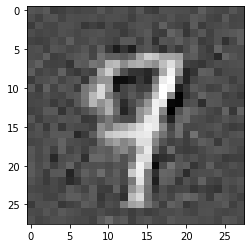

In [40]:
# generate image
import matplotlib.pyplot as plt
z = torch.randn(1, latent_size).to(device)
fake_imgs = G(z).view(28, 28).data.cpu().numpy()
plt.imshow(fake_imgs, cmap="gray")

In [42]:
# save model
def save_model():
    torch.save(D.state_dict(), 'GAN_Model/discriminator.pth')
    torch.save(G.state_dict(), 'GAN_Model/generator.pth')

In [ ]:
# load model
def load_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    D = Discriminator() # 不能和类同名
    G = Generator()
    D.to(device=device)
    G.to(device=device)
    D.load_state_dict(torch.load('GAN_Model/discriminator.pth', map_location=device))
    G.load_state_dict(torch.load('GAN_Model/generator.pth', map_location=device))
    return G, D